In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import gamma, factorial
from scipy.optimize import minimize

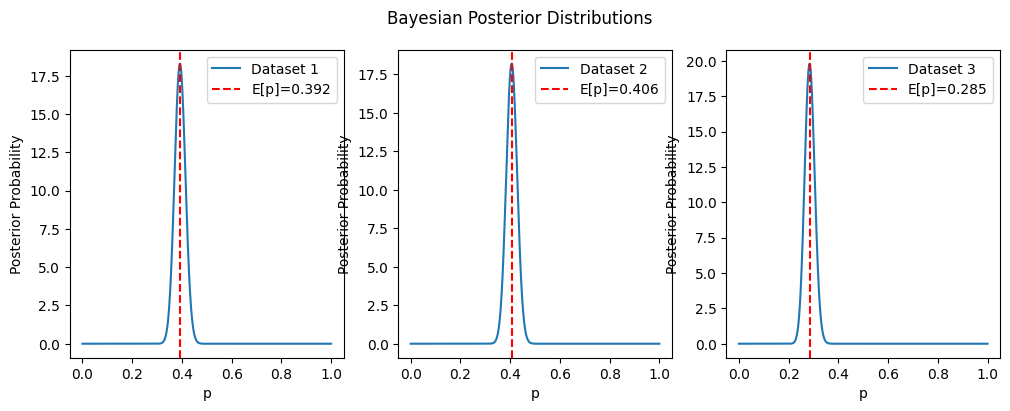

In [12]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return np.array(data)
# Load datasets
dataset_paths = [
    "dataset_1.json",
    "dataset_2.json",
    "dataset_3.json"
]

datasets = []
for path in dataset_paths:
    with open(path, 'r') as file:
        datasets.append(json.load(file))

# Bayesian Inference: Compute Posterior
def bayesian_posterior(M, N):
    alpha = M + 1
    beta = N - M + 1
    p_values = np.linspace(0, 1, 1000)
    posterior = stats.beta.pdf(p_values, alpha, beta)
    expectation = alpha / (alpha + beta)
    variance = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))
    return p_values, posterior, expectation, variance

# Compute and visualize posterior distributions
plt.figure(figsize=(12, 4))
for i, data in enumerate(datasets):
    M = sum(data)
    N = len(data)
    p_values, posterior, expectation, variance = bayesian_posterior(M, N)
    plt.subplot(1, 3, i+1)
    plt.plot(p_values, posterior, label=f'Dataset {i+1}')
    plt.axvline(expectation, color='r', linestyle='--', label=f'E[p]={expectation:.3f}')
    plt.xlabel('p')
    plt.ylabel('Posterior Probability')
    plt.legend()
plt.suptitle('Bayesian Posterior Distributions')
plt.show()


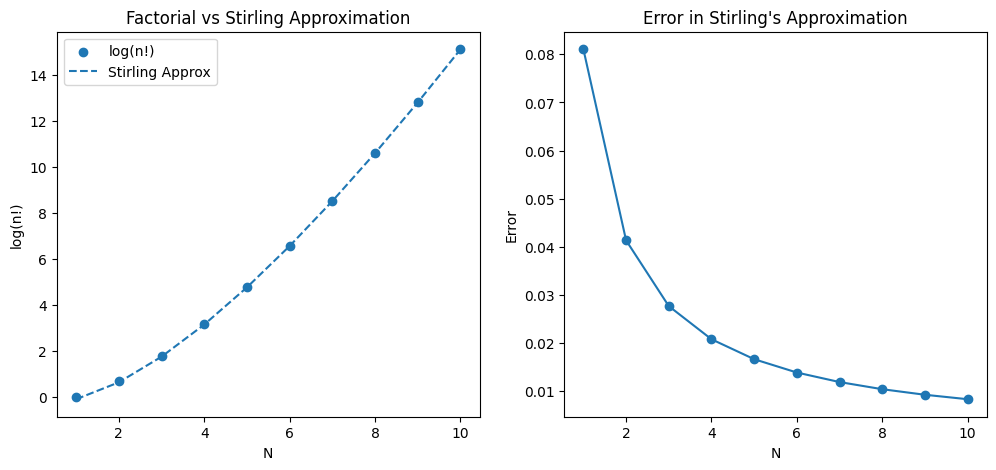

In [6]:
from scipy.special import gamma, factorial

# Compute Stirling’s approximation
def stirling_approximation():
    N_values = np.arange(1, 11)
    factorial_values = np.array([np.log(factorial(n)) for n in N_values])
    stirling_values = N_values * np.log(N_values) - N_values + 0.5 * np.log(2 * np.pi * N_values)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(N_values, factorial_values, label="log(n!)")
    plt.plot(N_values, stirling_values, label="Stirling Approx", linestyle="dashed")
    plt.xlabel("N")
    plt.ylabel("log(n!)")
    plt.legend()
    plt.title("Factorial vs Stirling Approximation")

    plt.subplot(1, 2, 2)
    plt.plot(N_values, factorial_values - stirling_values, marker='o')
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.title("Error in Stirling's Approximation")
    plt.show()

stirling_approximation()


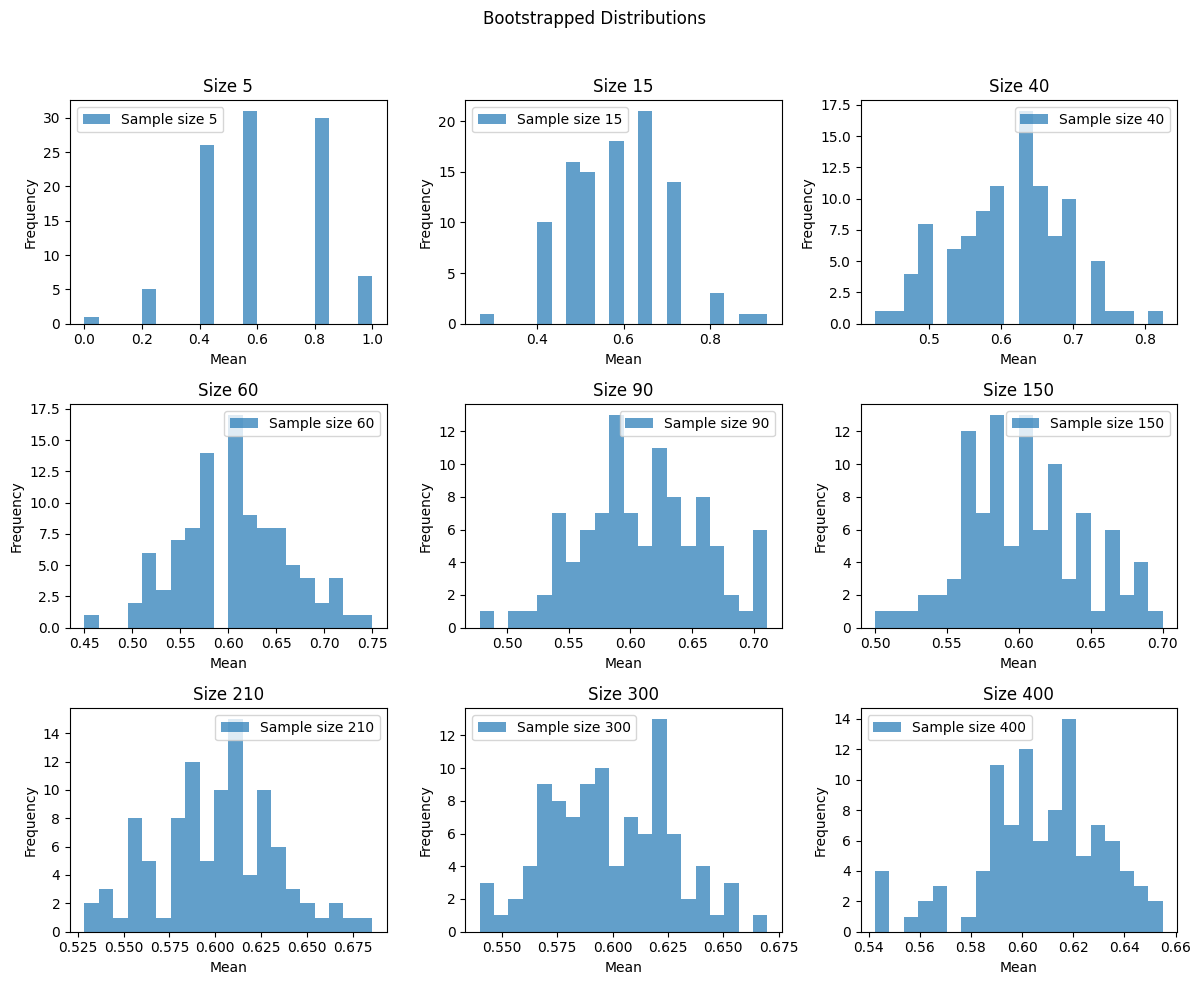

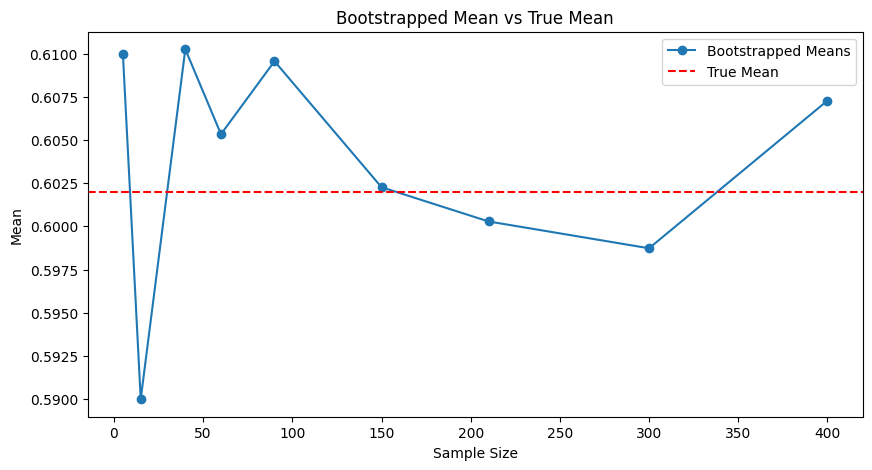

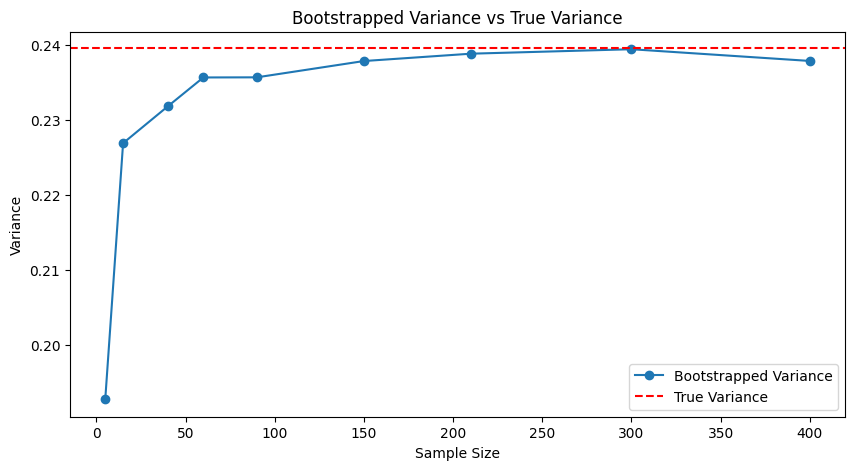

In [8]:
# Bootstrapping Analysis
def bootstrap(data, num_resamples, sample_sizes):
    means = {size: [] for size in sample_sizes}
    variances = {size: [] for size in sample_sizes}

    for size in sample_sizes:
        for _ in range(num_resamples):
            sample = np.random.choice(data, size=size, replace=True)
            means[size].append(np.mean(sample))
            variances[size].append(np.var(sample))

    return means, variances

def plot_bootstrapped_distributions(simulated_data, sample_sizes):
    boot_means, boot_vars = bootstrap(simulated_data, 100, sample_sizes)

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle("Bootstrapped Distributions")

    for i, size in enumerate(sample_sizes):
        ax = axes[i // 3, i % 3]
        ax.hist(boot_means[size], bins=20, alpha=0.7, label=f"Sample size {size}")
        ax.set_title(f"Size {size}")
        ax.set_xlabel("Mean")
        ax.set_ylabel("Frequency")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, [np.mean(boot_means[size]) for size in sample_sizes], marker='o', label="Bootstrapped Means")
    plt.axhline(y=np.mean(simulated_data), color='r', linestyle='--', label="True Mean")
    plt.xlabel("Sample Size")
    plt.ylabel("Mean")
    plt.legend()
    plt.title("Bootstrapped Mean vs True Mean")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, [np.mean(boot_vars[size]) for size in sample_sizes], marker='o', label="Bootstrapped Variance")
    plt.axhline(y=np.var(simulated_data), color='r', linestyle='--', label="True Variance")
    plt.xlabel("Sample Size")
    plt.ylabel("Variance")
    plt.legend()
    plt.title("Bootstrapped Variance vs True Variance")
    plt.show()

sample_sizes = [5, 15, 40, 60, 90, 150, 210, 300, 400]
plot_bootstrapped_distributions(simulated_data, sample_sizes)


Task 2

In [18]:
from scipy.optimize import minimize
# Exponential Decay Fit
def exponential_likelihood(lmbda, data):
    return -np.sum(np.log(1/lmbda * np.exp(-data/lmbda)))

def fit_exponential(data):
    result = minimize(lambda lmbda: exponential_likelihood(lmbda, data), x0=np.array([1.0]), bounds=[(0.01, None)])
    return result.x[0]

# Mixture model (Exponential + Gaussian)
def mixture_likelihood(params, data):
    lmbda, mu, sigma = params
    exp_part = (1/lmbda) * np.exp(-data/lmbda)
    gauss_part = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((data - mu)**2) / (2 * sigma**2))
    return -np.sum(np.log(0.5 * exp_part + 0.5 * gauss_part))

def fit_mixture_model(data):
    result = minimize(lambda params: mixture_likelihood(params, data), x0=np.array([1.0, np.mean(data), np.std(data)]), 
                      bounds=[(0.01, None), (None, None), (0.01, None)])
    return result.x

# Simulated decay data (replace with actual dataset)
vacuum_data = load_data("Vacuum_decay_dataset.json")
cavity_data = load_data("Cavity_decay_dataset.json")

lambda_vacuum = fit_exponential(vacuum_data)
lambda_cavity, mu_cavity, sigma_cavity = fit_mixture_model(cavity_data)

print(f"Estimated λ for Vacuum: {lambda_vacuum:.3f}")
print(f"Estimated λ: {lambda_cavity:.3f}, μ: {mu_cavity:.3f}, σ: {sigma_cavity:.3f}")


Estimated λ for Vacuum: 2.253
Estimated λ: 2.425, μ: 4.079, σ: 2.372


In [19]:
# Null Hypothesis Test
def null_hypothesis_test(vacuum_data, cavity_data):
    lmbda_vacuum = fit_exponential(vacuum_data)
    lmbda_cavity = fit_exponential(cavity_data)
    
    mixture_params = fit_mixture_model(cavity_data)
    
    null_likelihood = exponential_likelihood(lmbda_cavity, cavity_data)
    alt_likelihood = mixture_likelihood(mixture_params, cavity_data)
    
    likelihood_ratio = 2 * (null_likelihood - alt_likelihood)
    p_value = 1 - stats.chi2.cdf(likelihood_ratio, df=2)
    
    return p_value < 0.05  # True if null hypothesis rejected at 95% confidence

reject_null = null_hypothesis_test(vacuum_data, cavity_data)
print(f"Reject null hypothesis: {reject_null}")


Reject null hypothesis: True
